In [169]:
import tf_freq_id
import tracetools as tt
import matplotlib.pyplot as plt 
import numpy as np
import control as ctrl
from utils import *

ast = tt.parse_autotune_file(r'AST files\AST_AX7.xml')
s = ctrl.tf('s')

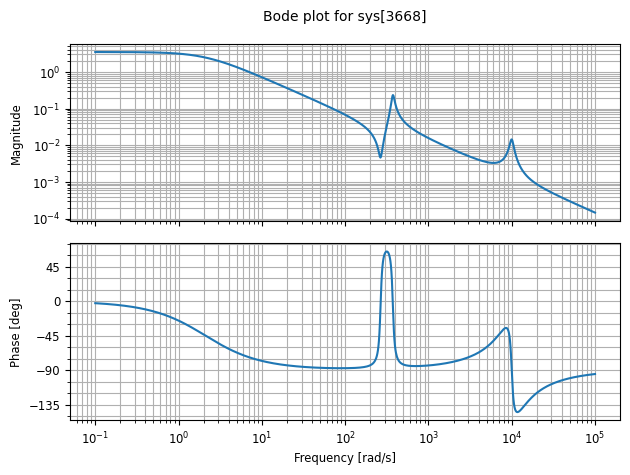

In [170]:

Gf = tf_from_txt(r'tf_txt\Gf.txt')

ctrl.bode(Gf)


In [171]:
Gf

TransferFunction(array([1.44707431e+01, 1.45028212e+05, 1.45130879e+09, 4.23448419e+10,
       1.02667459e+14]), array([1.00000000e+00, 1.03286306e+03, 1.00172763e+08, 3.42649869e+09,
       1.39902598e+13, 2.93312041e+13]))

# IMC Controller

0 states have been removed from the model


TransferFunction(array([98696.04401089]), array([1.00000000e+00, 4.44221201e+02, 9.86960440e+04]))

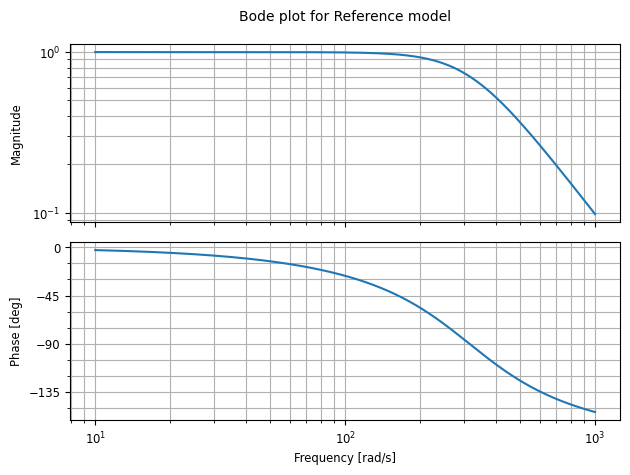

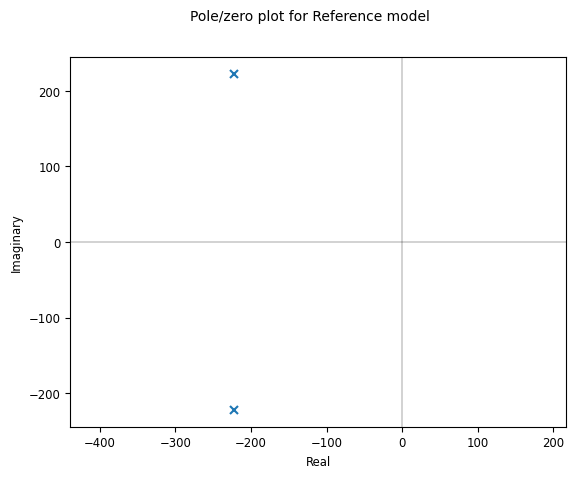

In [172]:

# Ref model
w_cl_m = 50*2*np.pi
#M = 1/(s/w_cl_m + 1)
M = pt2(w_cl_m,0.707)
M = ctrl.minreal(M)
M *= 1/M.dcgain()

M.name = 'Reference model'
ctrl.bode(M)

plt.figure()

ctrl.pzmap(M)

M

2 states have been removed from the model


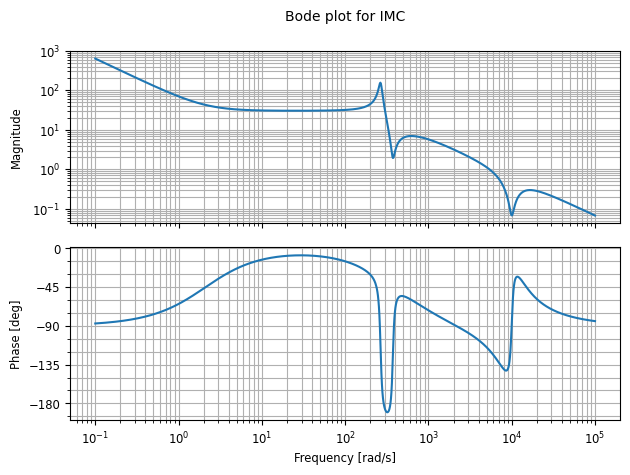

In [173]:
C_imc = M/(1-M) * (1/Gf)
C_imc = ctrl.minreal(C_imc)
C_imc.name = 'IMC'
ctrl.bode(C_imc)

In [174]:
def increase_damping(C,min_dampng):

    new_pole_poly = 1.0

    eps = 1e-6

    for z in C.poles():

        # Singe or complez pole?
        p = 1.0
        if np.abs(np.imag(z)) < eps:
            # real pole     
            
            z = np.real(z)
            if np.abs(z) > eps:
                p = (s-z)/(-z)
                p = (s/np.abs(z) + 1)
            else:
                p = (s-z)
        elif np.imag(z) > eps:


            w0 = np.sqrt(np.real(z)**2 + np.imag(z)**2)
            zeta = -np.real(z)/w0

            zeta = max(zeta,min_dampng)

            p = (s**2 + 2*zeta*w0*s + w0**2)/w0**2

        new_pole_poly *= p

    zero_poly = ctrl.tf(C.num[0][0],1)
    C_new = zero_poly/new_pole_poly


    gain0 = ctrl.frequency_response(C).response[0][0]
    gain0 = np.mean(np.abs(gain0))

    gain1 = ctrl.frequency_response(C_new).response[0][0]
    gain1 = np.mean(np.abs(gain1))

    C_new *= gain0/gain1


    return C_new



In [175]:
for z in Gf.zeros():
    if z.imag > 0:
        w = np.abs(z)
        print(w)

9999.999985488292
266.36121704829134


TransferFunction(array([3.55867720e+02, 3.57763507e+06, 3.58015988e+10, 2.14826926e+12,
       2.52482089e+15]), array([7.99465414e-02, 2.04138653e+02, 2.65597421e+05, 1.91224613e+08,
       8.30663675e+10, 1.81339456e+13, 2.52482089e+15]))

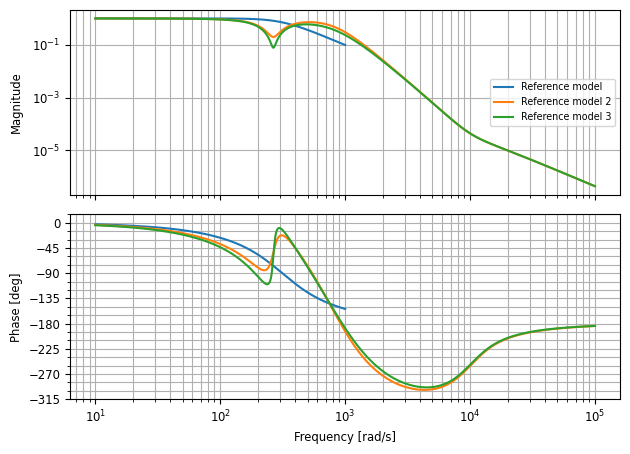

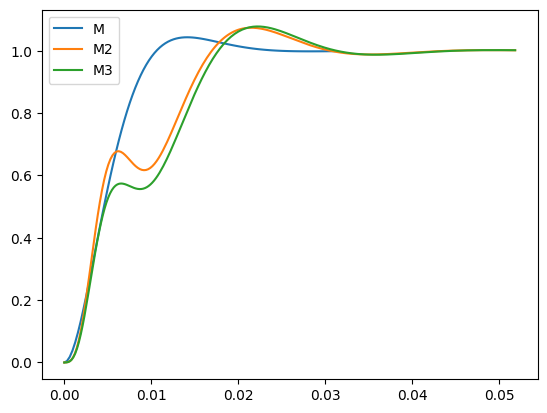

In [176]:

M2 = ctrl.tf(1,Gf.num[0][0]) # Only inverse zeros of Gf

M2 = 1/increase_damping(M2,0.1)
w_cl_2 = 130*2*np.pi
M2 *= pt2(266.36,0.5) * pt2(w_cl_2,0.7)**2
M2 *= 1/M2.dcgain()
M2.name = 'Reference model 2'


M3 = ctrl.tf(Gf.num[0][0],1) 

w_cl_3 = 160*2*np.pi
M3 *= pt2(266.36,0.5) * pt2(w_cl_2,0.8)**2
M3 *= 1/M3.dcgain()
M3.name = 'Reference model 3'


ctrl.bode(M)
ctrl.bode(M2)
ctrl.bode(M3)

plt.figure()

t0, y0 = ctrl.step_response(M)
t1, y1 = ctrl.step_response(M2)
t2, y2 = ctrl.step_response(M3)

plt.plot(t0,y0,label='M')
plt.plot(t1,y1,label='M2')
plt.plot(t2,y2,label='M3')
plt.legend()

M2

8 states have been removed from the model
10 states have been removed from the model


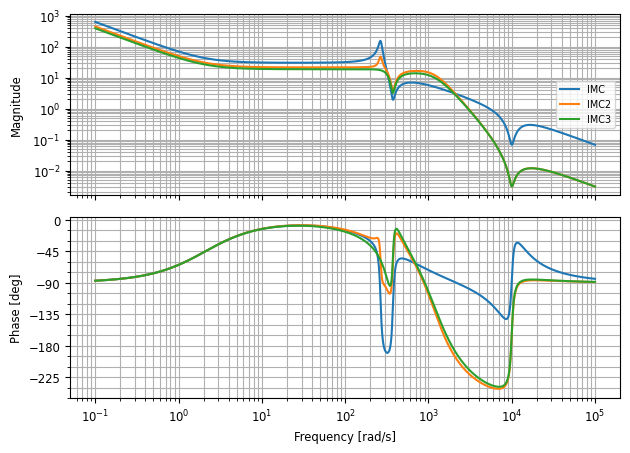

In [177]:

C_imc2 = M2/(1-M2) * (1/Gf)
C_imc2 = ctrl.minreal(C_imc2)
C_imc2.name = 'IMC2'

C_imc3 = M3/(1-M3) * (1/Gf)
C_imc3 = ctrl.minreal(C_imc3)
C_imc3.name = 'IMC3'


ctrl.bode(C_imc)
ctrl.bode(C_imc2)
ctrl.bode(C_imc3)

save_fig('imc_ctrl_increased_damping')



In [178]:

with open(r'tf_txt\C_imc.txt','w') as f:
    print_tf(C_imc,f)


# in the comparison notebook, C3 will be named C2 instead.
with open(r'tf_txt\C_imc2.txt','w') as f:
    print_tf(C_imc3,f)

#with open(r'tf_txt\C_imc3.txt','w') as f:
#    print_tf(C_imc3,f)

9 states have been removed from the model
7 states have been removed from the model
5 states have been removed from the model
2 states have been removed from the model
6 states have been removed from the model
6 states have been removed from the model


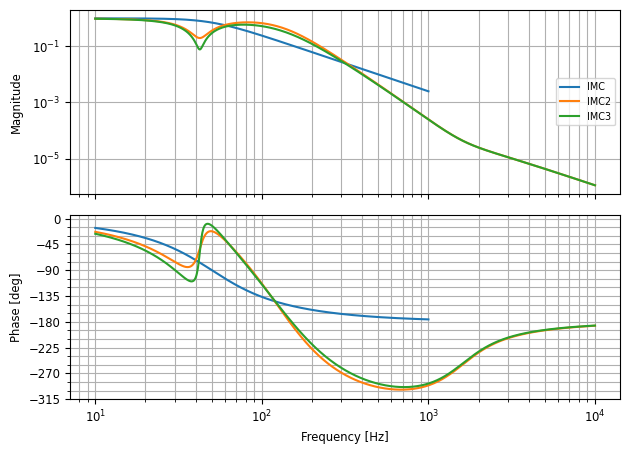

In [179]:
L_imc = C_imc*Gf
L_imc = ctrl.minreal(L_imc)

L_imc2 = C_imc2*Gf
L_imc2 = ctrl.minreal(L_imc2)

L_imc3 = C_imc3*Gf
L_imc3 = ctrl.minreal(L_imc3)

#ctrl.bode(L_imc,display_margins=True,Hz=True)

CL_imc = L_imc/(1+L_imc)
CL_imc = ctrl.minreal(CL_imc)
CL_imc.name = 'IMC'

CL_imc2 = L_imc2/(1+L_imc2)
CL_imc2 = ctrl.minreal(CL_imc2)
CL_imc2.name = 'IMC2'

CL_imc3 = L_imc3/(1+L_imc3)
CL_imc3 = ctrl.minreal(CL_imc3)
CL_imc3.name = 'IMC3'

plt.figure()
ctrl.bode(CL_imc,Hz=True)
ctrl.bode(CL_imc2,Hz=True)
ctrl.bode(CL_imc3,Hz=True)


0 states have been removed from the model
0 states have been removed from the model
0 states have been removed from the model


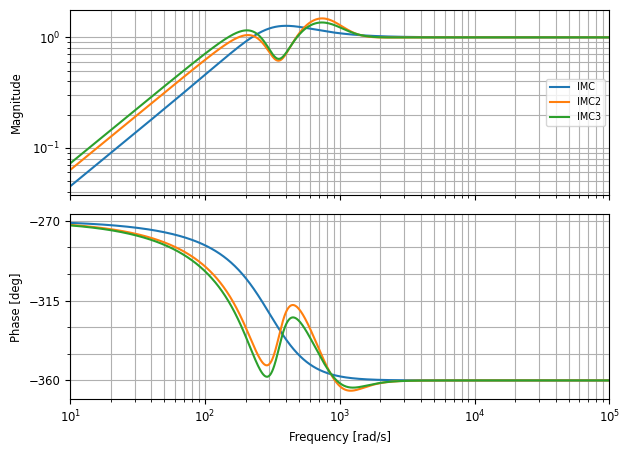

In [180]:


S_imc = 1/(1+L_imc)
S_imc = ctrl.minreal(S_imc)
S_imc.name = 'IMC'

S_imc2 = 1/(1+L_imc2)
S_imc2 = ctrl.minreal(S_imc2)
S_imc2.name = 'IMC2'

S_imc3 = 1/(1+L_imc3)
S_imc3 = ctrl.minreal(S_imc3)
S_imc3.name = 'IMC3'

omega_lim = [10,1e5]

ctrl.bode(S_imc,omega_limits=omega_lim)
ctrl.bode(S_imc2,omega_limits=omega_lim)
ctrl.bode(S_imc3,omega_limits=omega_lim)